In [1]:
%install_ext https://raw.github.com/jrjohansson/ipython-asymptote/master/asymptote.py
!pip install --upgrade pip
!pip install graphviz
!pip install pyparsing
!pip install pydot
!pip install Wand
!brew install imagemagick 

Installed asymptote.py. To use it, type:
  %load_ext asymptote
Requirement already up-to-date: pip in /usr/local/lib/python2.7/site-packages


In [2]:
%reload_ext asymptote

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pydot
from wand.image import Image as WImage

Couldn't import dot_parser, loading of dot files will not be possible.


<a id="fig:weltkugel"></a>
**Abbildung: Schematische Darstellung der Weltkugel**

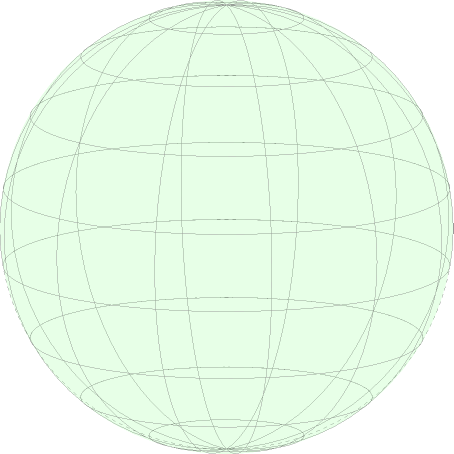

In [4]:
%%asy --root Images/world_coordinatesystem
//settings.render = 16;
import three;
import graph3;
import solids;
currentprojection=orthographic(9, 3, 2);
currentlight=nolight;

size(16cm);

real RE = 1;
revolution Earth=sphere(O, RE, 9);

draw(surface(Earth),surfacepen=white+green+opacity(.1), meshpen=0.6*white);
draw(Earth,m=10,0.6*white);

//draw(rotate(90,X) * path3(unitcircle), black, L=Label("$Greenwich$"));
//draw(path3(unitcircle), black, L=Label("$Equator$"));

//draw(rotate(45, Z) * rotate(45, Y) * (Z--1.5Z), red, Arrow3(emissive(red)), L=Label("$Z_{world}$", position=EndPoint));
//draw(path3(arc((0,0),1,0,45)), red, arrow=Arrow3(emissive(red)), L=Label("$Longitude$"));
//draw(rotate(45,Z) * rotate(90,X) * path3(arc((0,0),1,0,45)), red, arrow=Arrow3(emissive(red)), L=Label("$Latitude$"));

//draw(rotate(45,Y) * surface(path3(unitsquare)), green+opacity(0.2));

### Im Sensorkoordinatensystem

#### Ohne Bewegungskorrektur

In [5]:
Ausgangspose = pydot.Node('Ausgangspose (AP)', shape='rectangle', group='g1')
Bewegung = pydot.Node('Bewegungsänderung', shape='none', group='g2')

ICP  = pydot.Node('ICP', shape='doubleoctagon', group='g2')
IMU  = pydot.Node('IMU', shape='doubleoctagon', group='g2')
Abgleich  = pydot.Node('Abgleich', shape='doubleoctagon', group='g2')
MontagePose = pydot.Node('Montagepose', shape='rectangle', group='g2')
Endpose = pydot.Node('Endpose (EP)', shape='rectangle', group='g3')

inputs = pydot.Subgraph(rank='same')
inputs.add_node(Ausgangspose)
inputs.add_node(Bewegung)
inputs.add_node(Endpose)

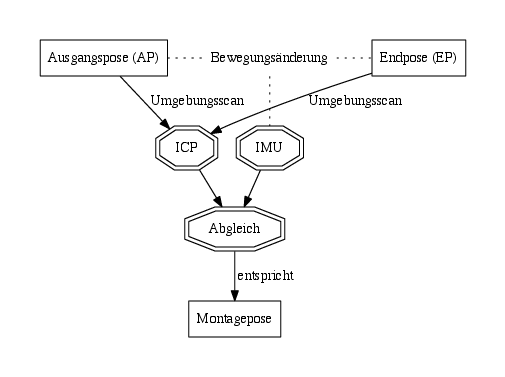

In [6]:
graph = pydot.Dot(graph_type='digraph')

graph.add_subgraph(inputs)
graph.add_node(MontagePose)
graph.add_node(ICP)
graph.add_node(IMU)
graph.add_node(Abgleich)

graph.add_edge(pydot.Edge(Ausgangspose, ICP, label='\ Umgebungsscan'))
graph.add_edge(pydot.Edge(Endpose, ICP, label='\ Umgebungsscan'))
graph.add_edge(pydot.Edge(Ausgangspose, Bewegung, style='dotted', arrowhead='none'))
graph.add_edge(pydot.Edge(Bewegung, Endpose, style='dotted', arrowhead='none'))
graph.add_edge(pydot.Edge(Bewegung, IMU, style='dotted', arrowhead='none'))

graph.add_edge(pydot.Edge(ICP, Abgleich))
graph.add_edge(pydot.Edge(IMU, Abgleich))
    
graph.add_edge(pydot.Edge(Abgleich, MontagePose, label='\ entspricht'))

graph.write_pdf('Images/kalibrierungImSC.pdf')
img = WImage(filename='Images/kalibrierungImSC.pdf')
img

#### Mit Bewegungskorrektur

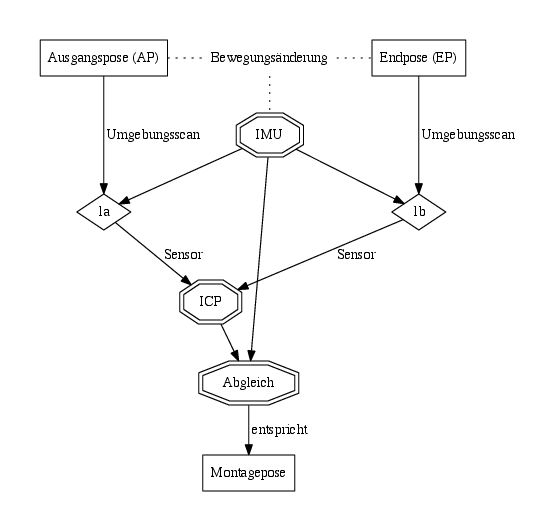

In [7]:
graph = pydot.Dot(graph_type='digraph')

Scan_zu_SK1 = pydot.Node('1a', shape='diamond', group='g1')
Scan_zu_SK2 = pydot.Node('1b', shape='diamond', group='g3')

graph.add_subgraph(inputs)
graph.add_node(Scan_zu_SK1)
graph.add_node(Scan_zu_SK2)
graph.add_node(MontagePose)
graph.add_node(ICP)
graph.add_node(IMU)
graph.add_node(Abgleich)

graph.add_edge(pydot.Edge(Ausgangspose, Scan_zu_SK1, label='\ Umgebungsscan'))
graph.add_edge(pydot.Edge(Endpose, Scan_zu_SK2, label='\ Umgebungsscan'))
graph.add_edge(pydot.Edge(Scan_zu_SK1, ICP, label='\ Sensor'))
graph.add_edge(pydot.Edge(Scan_zu_SK2, ICP, label='\ Sensor'))
graph.add_edge(pydot.Edge(Ausgangspose, Bewegung, style='dotted', arrowhead='none'))
graph.add_edge(pydot.Edge(Bewegung, Endpose, style='dotted', arrowhead='none'))
graph.add_edge(pydot.Edge(Bewegung, IMU, style='dotted', arrowhead='none'))
graph.add_edge(pydot.Edge(IMU, Scan_zu_SK1))
graph.add_edge(pydot.Edge(IMU, Scan_zu_SK2))

graph.add_edge(pydot.Edge(ICP, Abgleich))
graph.add_edge(pydot.Edge(IMU, Abgleich))
    
graph.add_edge(pydot.Edge(Abgleich, MontagePose, label='\ entspricht'))

graph.write_pdf('Images/kalibrierungImSCmitKorr.pdf')
img = WImage(filename='Images/kalibrierungImSCmitKorr.pdf')
img

### Im Weltkoordinatensystem

#### Ohne Bewegungskorrektur

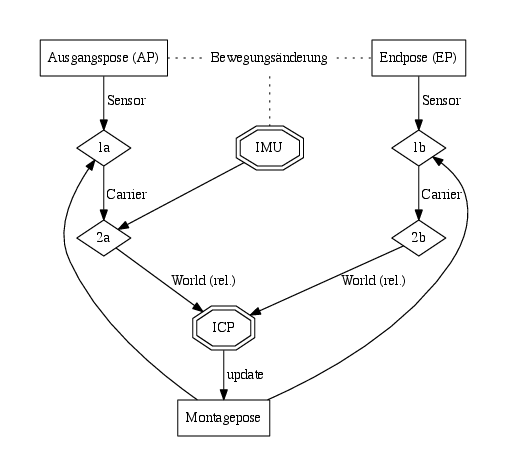

In [8]:
graph = pydot.Dot(graph_type='digraph')

SK_zu_TK1 = pydot.Node('1a', shape='diamond', group='g1')
SK_zu_TK2 = pydot.Node('1b', shape='diamond', group='g3')
TK_zu_WK1 = pydot.Node('2a', shape='diamond', group='g1')
TK_zu_WK2 = pydot.Node('2b', shape='diamond', group='g3')

scs = pydot.Subgraph(rank='same')
scs.add_node(SK_zu_TK1)
scs.add_node(SK_zu_TK2)

graph.add_subgraph(inputs)
graph.add_subgraph(scs)
graph.add_node(TK_zu_WK1)
graph.add_node(TK_zu_WK2)
graph.add_node(MontagePose)
graph.add_node(ICP)
graph.add_node(IMU)

graph.add_edge(pydot.Edge(Ausgangspose, Scan_zu_SK1, label='\ Sensor'))
graph.add_edge(pydot.Edge(Endpose, Scan_zu_SK2, label='\ Sensor'))
graph.add_edge(pydot.Edge(Scan_zu_SK1, TK_zu_WK1, label='\ Carrier'))
graph.add_edge(pydot.Edge(Scan_zu_SK2, TK_zu_WK2, label='\ Carrier'))
graph.add_edge(pydot.Edge(TK_zu_WK1, ICP, label='\ World\ (rel.)'))
graph.add_edge(pydot.Edge(TK_zu_WK2, ICP, label='\ World\ (rel.)'))
graph.add_edge(pydot.Edge(Ausgangspose, Bewegung, style='dotted', arrowhead='none'))
graph.add_edge(pydot.Edge(Bewegung, Endpose, style='dotted', arrowhead='none'))
graph.add_edge(pydot.Edge(Bewegung, IMU, style='dotted', arrowhead='none'))

graph.add_edge(pydot.Edge(IMU, TK_zu_WK1))
graph.add_edge(pydot.Edge(ICP, MontagePose, label='\ update'))
graph.add_edge(pydot.Edge(MontagePose, Scan_zu_SK1))
graph.add_edge(pydot.Edge(MontagePose, Scan_zu_SK2))

graph.write_pdf('Images/kalibrierungImWC.pdf')
img = WImage(filename='Images/kalibrierungImWC.pdf')
img

#### Mit Bewegungskorrektur

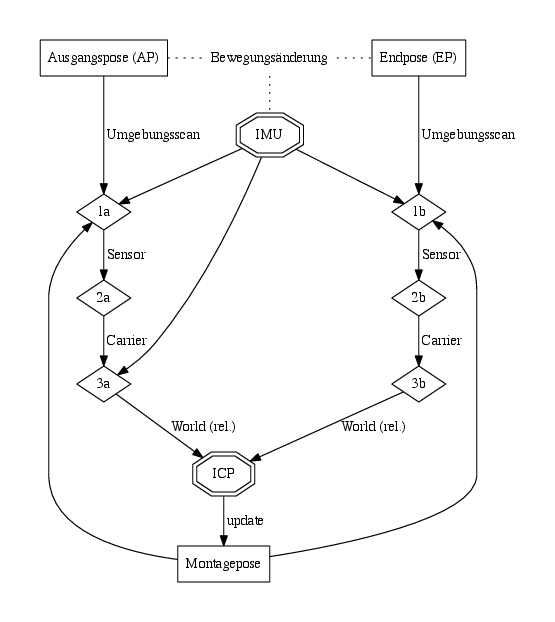

In [9]:
graph = pydot.Dot(graph_type='digraph')

SK_zu_TK1 = pydot.Node('2a', shape='diamond', group='g1')
SK_zu_TK2 = pydot.Node('2b', shape='diamond', group='g3')
TK_zu_WK1 = pydot.Node('3a', shape='diamond', group='g1')
TK_zu_WK2 = pydot.Node('3b', shape='diamond', group='g3')

graph.add_subgraph(inputs)
graph.add_node(Scan_zu_SK1)
graph.add_node(Scan_zu_SK2)
graph.add_node(SK_zu_TK1)
graph.add_node(SK_zu_TK2)
graph.add_subgraph(scs)
graph.add_node(TK_zu_WK1)
graph.add_node(TK_zu_WK2)
graph.add_node(MontagePose)
graph.add_node(ICP)
graph.add_node(IMU)

graph.add_edge(pydot.Edge(Ausgangspose, Scan_zu_SK1, label='\ Umgebungsscan'))
graph.add_edge(pydot.Edge(Endpose, Scan_zu_SK2, label='\ Umgebungsscan'))
graph.add_edge(pydot.Edge(Scan_zu_SK1, SK_zu_TK1 , label='\ Sensor'))
graph.add_edge(pydot.Edge(Scan_zu_SK2, SK_zu_TK2, label='\ Sensor'))
graph.add_edge(pydot.Edge(SK_zu_TK1, TK_zu_WK1, label='\ Carrier'))
graph.add_edge(pydot.Edge(SK_zu_TK2, TK_zu_WK2, label='\ Carrier'))
graph.add_edge(pydot.Edge(TK_zu_WK1, ICP, label='\ World\ (rel.)'))
graph.add_edge(pydot.Edge(TK_zu_WK2, ICP, label='\ World\ (rel.)'))
graph.add_edge(pydot.Edge(Ausgangspose, Bewegung, style='dotted', arrowhead='none'))
graph.add_edge(pydot.Edge(Bewegung, Endpose, style='dotted', arrowhead='none'))
graph.add_edge(pydot.Edge(Bewegung, IMU, style='dotted', arrowhead='none'))

graph.add_edge(pydot.Edge(IMU, Scan_zu_SK1))
graph.add_edge(pydot.Edge(IMU, Scan_zu_SK2))
graph.add_edge(pydot.Edge(IMU, TK_zu_WK1))
graph.add_edge(pydot.Edge(ICP, MontagePose, label='\ update'))
graph.add_edge(pydot.Edge(MontagePose, Scan_zu_SK1))
graph.add_edge(pydot.Edge(MontagePose, Scan_zu_SK2))

graph.write_pdf('Images/kalibrierungImWCmitKorr.pdf')
img = WImage(filename='Images/kalibrierungImWCmitKorr.pdf')
img

Laserscanner Velodyne HDL-32e

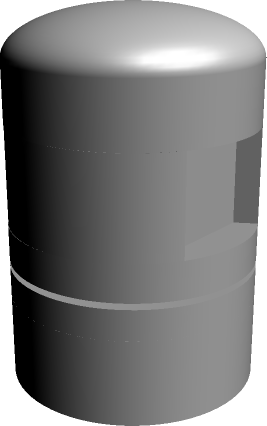

In [10]:
%%asy --root Images/velodyne
import solids;

surface velodyne() {
    real heightV=.8;
    path3 laserBase = path3((-0.4,0.7) -- (-0.5,sin(acos(-0.5))) .. (-1,0) .. (0,-1) .. (1,0) .. (0.5,sin(acos(0.5))) -- (0.4,0.7));

    surface top = shift(0.9Z) * scale(1,1,0.4) * unithemisphere;
    surface upperhead = surface(shift(0.4Z) * scale(1,1,0.5) * unitcylinder);
    surface laserEye = surface(shift(heightV/2*Z) * surface(unitcircle), shift(-heightV/2*Z) * extrude(laserBase --- cycle, heightV*Z), shift(-heightV/2*Z) * surface(unitcircle));
    surface lowerhead = surface(shift(-0.7Z) * scale(1,1,0.3) * unitcylinder, shift(-1Z) * surface(unitcircle));
    surface base = surface(shift(-0.75Z) * surface(unitcircle), shift(-1.7Z) * scale(1,1,0.95) * unitcylinder);
    surface velodyne = surface(top, upperhead, laserEye, lowerhead, base);

    return velodyne;
}

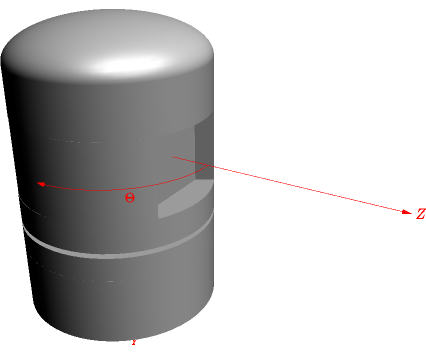

In [11]:
%%asy --root Images/velodyne_sc
import three;
import "Images/velodyne" as laserscanner;

//settings.render=16;
size(15cm);

draw(velodyne(), surfacepen=white);
draw(rotate(-90,X) * (O--2.5Y), red, Arrow3(emissive(red)), L=Label("$Y$", position=EndPoint));
draw(rotate(-90,X) * (O--3Z), red, Arrow3(emissive(red)), L=Label("$Z$", position=EndPoint));
draw(rotate(-90,X) * arc(c=(0,0,0),1.1Z, 1.1X), red, arrow=Arrow3(emissive(red)), L=Label("$\Theta$"));

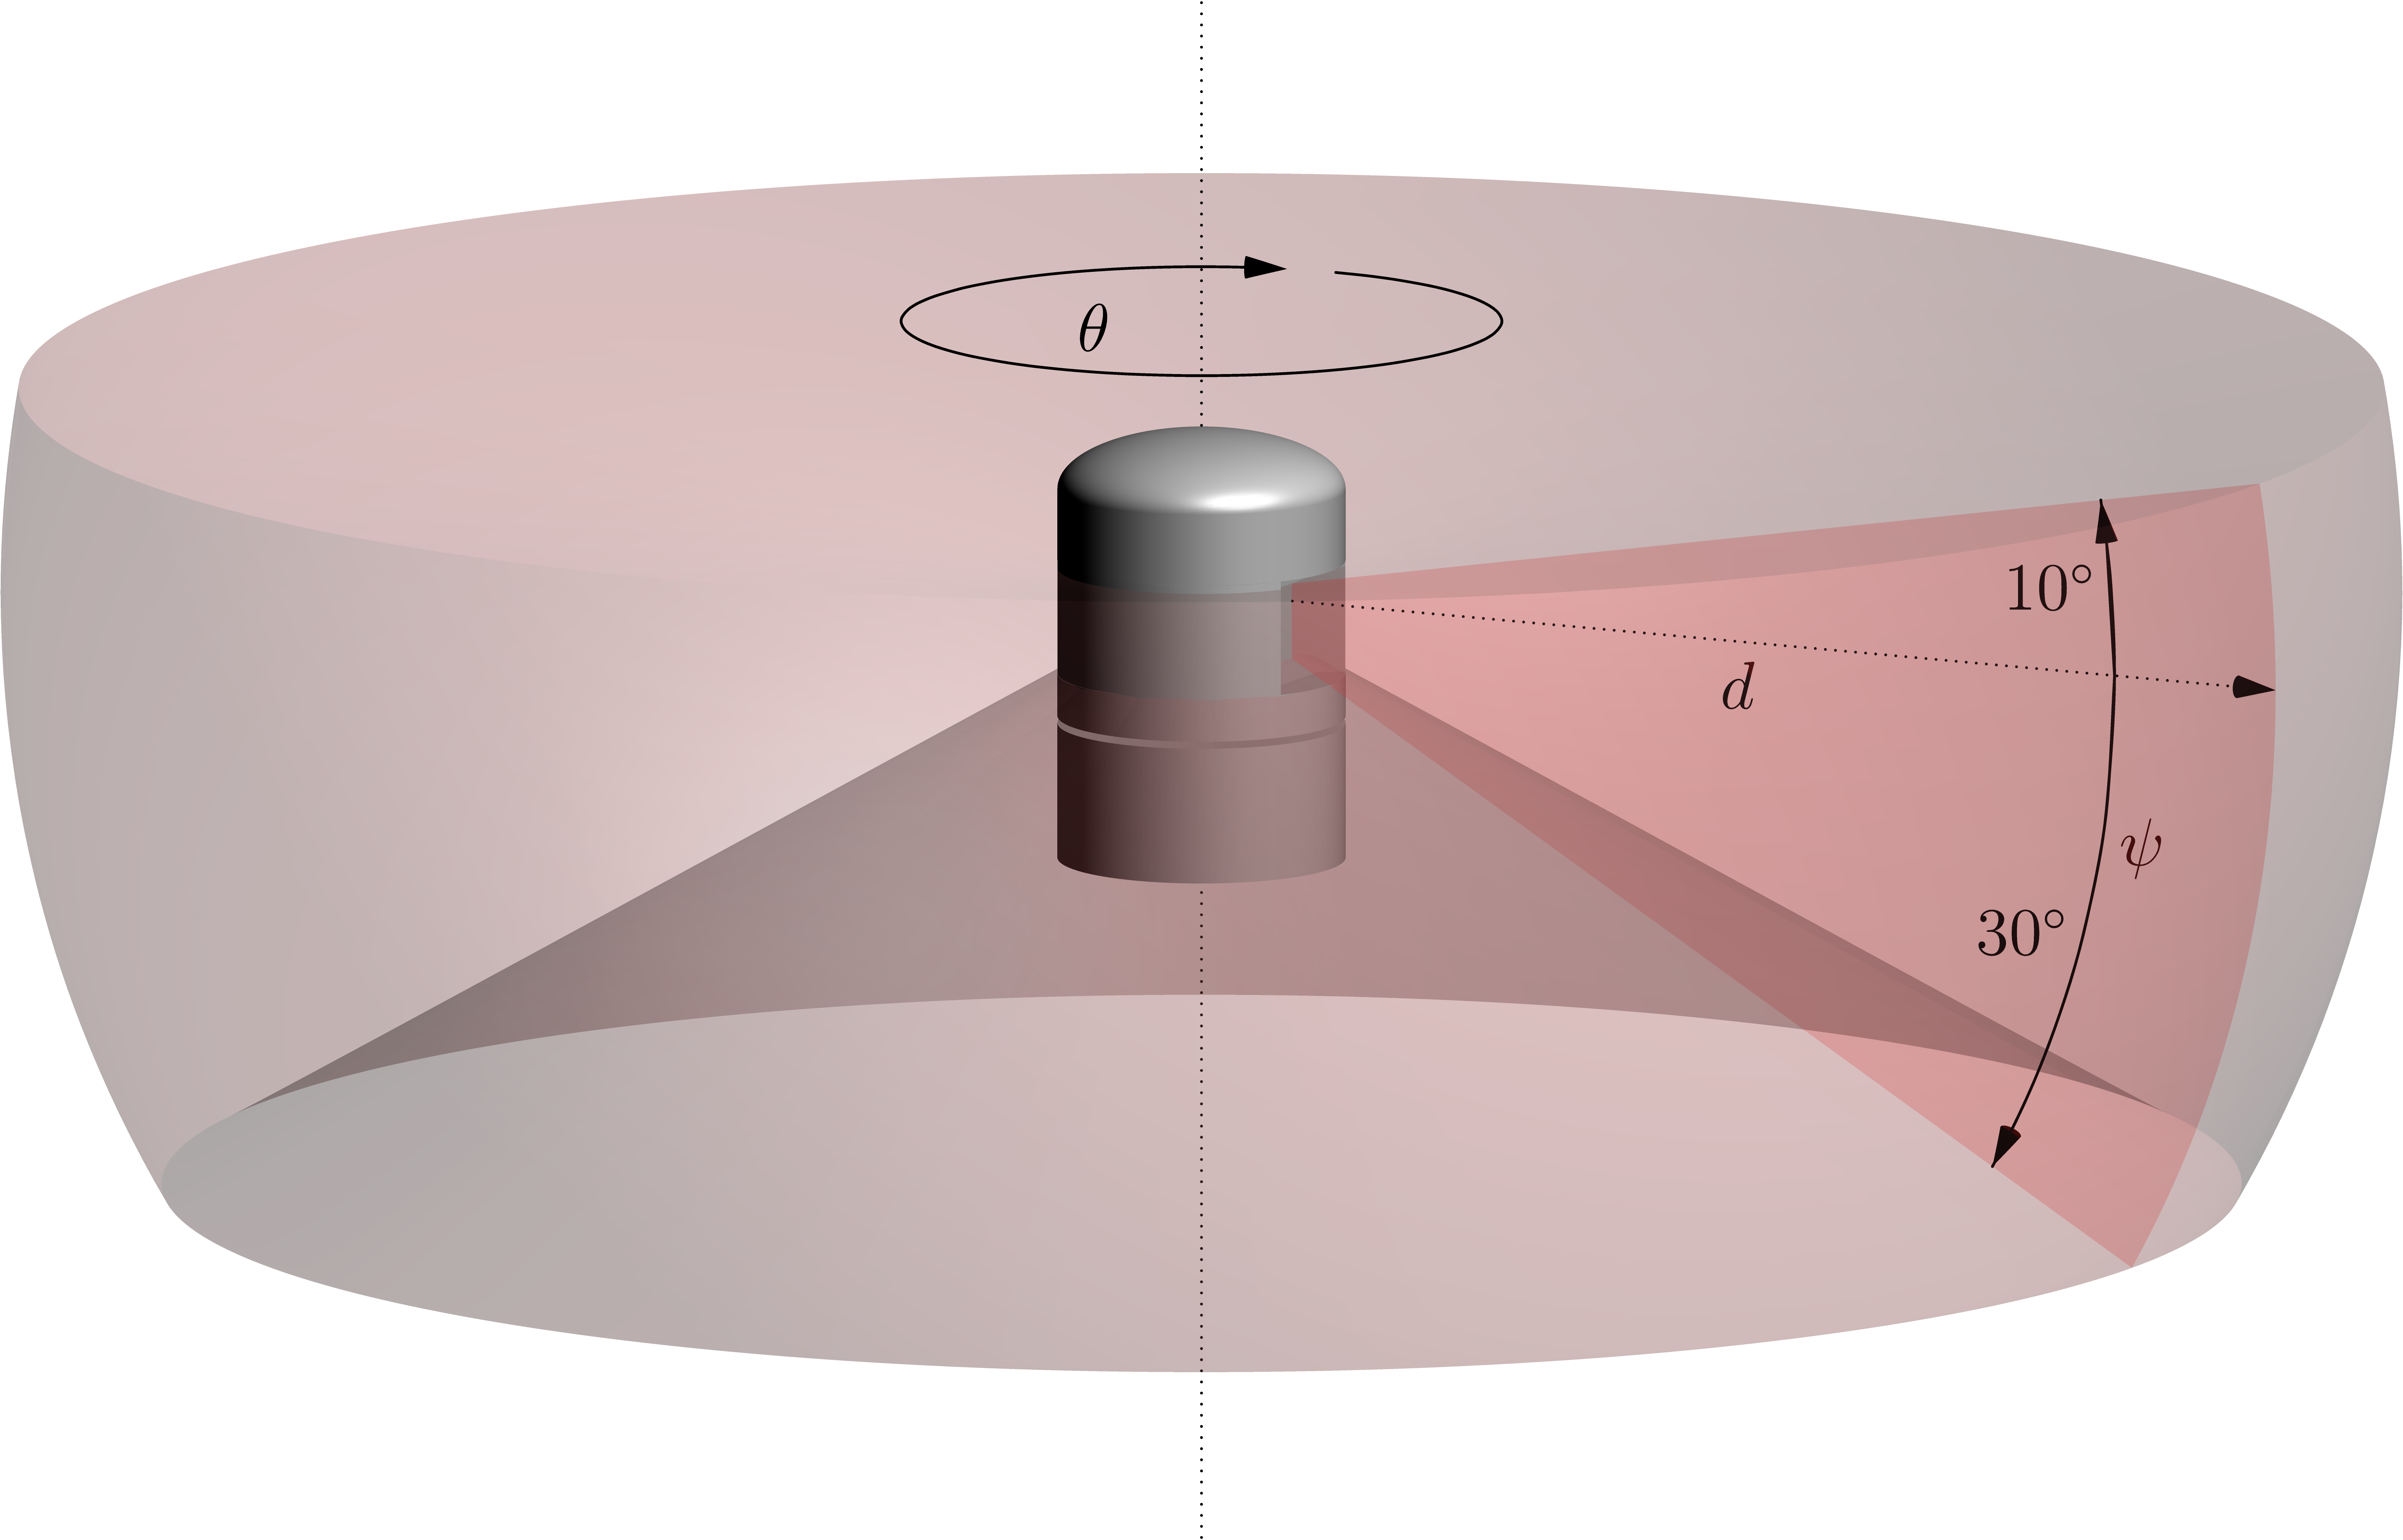

In [12]:
%%asy --root Images/velodyne_view
import three;
import "Images/velodyne" as laserscanner;
texpreamble("\usepackage{lmodern}");

size(15cm);
settings.render=16;
currentprojection=orthographic(8,4,1.5, center=true);

pen outside = white+opacity(1);
pen viewpoint = red+white;

draw(shift(-.02Z) * scale(.12,.12,.12) * velodyne(), outside);

path3 view = rotate(90,X) * path3((0,0) -- arc((0,0), 1, 10, -30) --- cycle);
draw(surface(rotate(90, Z) * view), emissive(red+black+opacity(0.2)));
draw(surface(revolution(view)), viewpoint+opacity(0.2));

draw(-.8Z -- .5Z, linetype(new real[] {0,4}));
draw(shift(0,0,.23) * path3(arc((0,0),.25, 180, -170)), black, arrow=Arrow3(emissive(black)), L=Label("$\theta$"));
draw(rotate(90,Z) * rotate(90,X) * path3(arc((0,0),.85, -30, 10)), L=Label("$\psi$", align=E));
draw(rotate(90,Z) * rotate(90,X) * path3(arc((0,0),.85, 0, 10)), arrow=Arrow3(emissive(black)), L=Label("$10^{\circ}$", align=W));
draw(rotate(90,Z) * rotate(90,X) * path3(arc((0,0),.85, 0, -30)), arrow=Arrow3(emissive(black)), L=Label("$30^{\circ}$", align=W));
draw(rotate(-90,X) * (O--1Z), linetype(new real[] {0,4}), arrow=Arrow3(emissive(black)), L=Label("$d$", align=S));

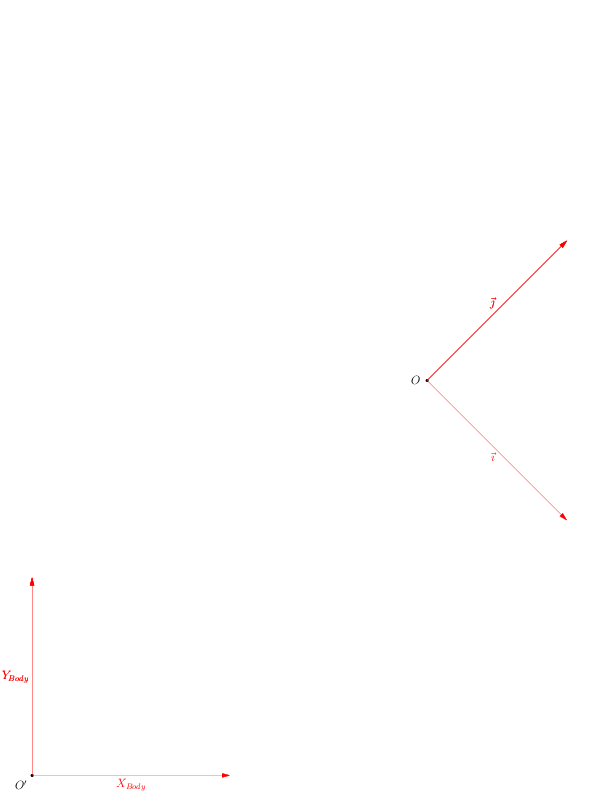

In [15]:
%%asy --root Images/carrier
import geometry;
texpreamble("\usepackage{lmodern}");

size(20cm,0);
//settings.render=16;

show("$O'$", "$X_{Body}$", "$Y_{Body}$", currentcoordsys, xpen=invisible);
show(shift(2,2) * rotate(-45) * currentcoordsys, xpen=invisible);

In [ ]:
%%asy --root Images/carrier